# eQQMIX : Entangled Quantum QMIX Algorithm -- eQVDN

Multi-agent learning by deriving $Q_{tot}$ from GHZ-entangled agent PQCs and joint measurements.

Inspired by the tutorial: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#3_deep_q-learning_with_pqc_q-function_approximators

In [381]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [382]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

# from eqmarl import *
import cirq
import sympy
import tensorflow_quantum as tfq
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image

In [383]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [384]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime() -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start


# with catchtime() as t:
#     import time
#     time.sleep(1)

# print(f"Execution time: {t():.4f} secs")

## Environment: Coin Game

Source: https://dl.acm.org/doi/10.5555/3535850.3535967

GitHub citation: https://github.com/thomyphan/emergent-cooperation/blob/main/mate/environments/coin_game.py

In [385]:
"""
This environment was gleaned from the work of https://dl.acm.org/doi/10.5555/3535850.3535967

GitHub source: https://github.com/thomyphan/emergent-cooperation/blob/main/mate/environments/coin_game.py
"""

import numpy
import random

class Environment:

    def __init__(self, params) -> None:
        self.domain_value_labels = params["domain_value_labels"]
        self.observation_dim = params["observation_dim"]
        self.nr_agents = params["nr_agents"]
        self.nr_actions = params["nr_actions"]
        self.time_limit = params["time_limit"]
        self.gamma = params["gamma"]
        self.time_step = 0
        self.sent_gifts = numpy.zeros(self.nr_agents)
        self.discounted_returns = numpy.zeros(self.nr_agents)
        self.undiscounted_returns = numpy.zeros(self.nr_agents)
        self.domain_counts = numpy.zeros(len(self.domain_value_labels))
        self.last_joint_action = -numpy.ones(self.nr_agents, dtype='int')

    """
     Performs the joint action in order to change the environment.
     Returns the reward for each agent in a list sorted by agent ID.
    """
    def perform_step(self, joint_action):
        assert not self.is_done(), "Episode terminated at time step {}. Please, reset before calling 'step'."\
            .format(self.time_step)
        return numpy.zeros(self.nr_agents), {}

    """
     Indicates if an episode is done and the environments needs
     to be reset.
    """
    def is_done(self):
        return self.time_step >= self.time_limit

    def action_as_vector(self, action):
        if action < self.nr_actions:
            vector = numpy.zeros(self.nr_actions)
            if action >= 0:
                vector[action] = 1
        else:
            vector = numpy.ones(self.nr_actions)
        return vector

    """
     Performs a joint action to change the state of the environment.
     Returns the joint observation, the joint reward, a done flag,
     and other optional information (e.g., logged data).
     Note: The joint action must be a list ordered according to the agent ID!.
    """
    def step(self, joint_action):
        assert len(joint_action) == self.nr_agents, "Length of 'joint_action' is {}, expected {}"\
            .format(len(joint_action), self.nr_agents)
        assert not self.is_done(), "Episode terminated at time step {}. Please, reset before calling 'step'."\
            .format(self.time_step)
        rewards, infos = self.perform_step(joint_action)
        for i, a in enumerate(joint_action):
            self.last_joint_action[i] = a
            if a >= self.nr_actions:
                self.sent_gifts[i] += 1
        assert len(rewards) == self.nr_agents, "Length of 'rewards' is {}, expected {}"\
            .format(len(rewards), self.nr_agents)
        observations = self.joint_observation()
        assert len(observations) == self.nr_agents, "Length of 'observations' is {}, expected {}"\
            .format(len(observations), self.nr_agents)
        self.time_step += 1
        self.domain_counts[0] += 1.0
        self.undiscounted_returns += rewards
        self.discounted_returns += (self.gamma**self.time_step)*rewards
        if "neighbor_agents" not in infos:
            infos["neighbor_agents"] = [[j for j in range(self.nr_agents) if j != i] for i in range(self.nr_agents)]
        return observations, rewards, self.is_done(), infos

    def get_index(self, label):
        return self.domain_value_labels.index(label)

    """
     The local observation for a specific agent. Only visible for
     the corresponding agent and private to others.
    """
    def local_observation(self, agent_id):
        pass

    """
     Returns the observations of all agents in a listed sorted by agent ids.
    """
    def joint_observation(self):
        return [numpy.array(self.local_observation(i)).reshape(self.observation_dim) for i in range(self.nr_agents)]

    """
     Returns a high-level value which is domain-specific.
    """
    def domain_values(self):
        return self.domain_counts

    def domain_value_debugging_indices(self):
        return 0,1

    """
     Re-Setup of the environment for a new episode.
    """
    def reset(self):
        self.time_step = 0
        self.discounted_returns[:] = 0
        self.undiscounted_returns[:] = 0
        self.last_joint_action[:] = -1
        self.domain_counts[:] = 0
        self.sent_gifts[:] = 0
        return self.joint_observation()
    


MOVE_NORTH = 0
MOVE_SOUTH = 1
MOVE_WEST = 2
MOVE_EAST = 3

COIN_GAME_ACTIONS = [MOVE_NORTH, MOVE_SOUTH, MOVE_WEST, MOVE_EAST]

class MovableAgent:

    def __init__(self, agent_id, width, height, view_range):
        self.agent_id = agent_id
        self.position = None
        self.width = width
        self.height = height
        self.view_range = view_range

    def move(self, action):
        x, y = self.position
        if action == MOVE_NORTH and y + 1 < self.height:
            self.position = (x, y + 1)
        if action == MOVE_SOUTH and y - 1 >= 0:
            self.position = (x, y - 1)
        if action == MOVE_EAST and x + 1 < self.width:
            self.position = (x + 1, y)
        if action == MOVE_WEST and x - 1 >= 0:
            self.position = (x - 1, y)

    def reset(self, position):
        self.position = position

    def visible_positions(self):
        x0, y0 = self.position
        x_center = int(self.view_range/2)
        y_center = int(self.view_range/2)
        positions = [(x,y) for x in range(-x_center+x0, x_center+1+x0)\
            for y in range(-y_center+y0, y_center+1+y0)]
        return positions

    def relative_position_to(self, other_position):
        dx = other_position[0] - self.position[0]
        dy = other_position[1] - self.position[1]
        return dx, dy

class Coin:

    def __init__(self, nr_agents):
        self.agent_ids = list(range(nr_agents))
        self.agent_id = None # Indicates color of coin
        self.position = None

    def reset(self, position):
        self.position = position
        self.agent_id = random.choice(self.agent_ids)


# Observation shape for "CoinGame-2" is (4,3,3) which means:
# - index=0: 3x3 grid world with a `1` where the current agent is.
# - index=1: 3x3 grid world where a `1` is added to every cell that has other agents.
# - index=2: 3x3 grid world with a `1` for location of coin that matches the focused agent's color.
# - index=3: 3x3 grid world with a `1` for location of coin that matches other agent's color.

class CoinGameEnvironment(Environment):

    def __init__(self, params):
        params["domain_value_labels"] = ["time_steps", "coins_collected", "own_coins_collected", "coin_1_generated"]
        super(CoinGameEnvironment, self).__init__(params)
        self.width = params["width"]
        self.height = params["height"]
        self.view_range = params["view_range"]
        self.observation_shape = (4, self.width, self.height)
        self.agents = [MovableAgent(i, self.width, self.height, self.view_range) for i in range(self.nr_agents)]
        self.positions = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.coin = Coin(self.nr_agents)

    def perform_step(self, joint_action):
        rewards, infos = super(CoinGameEnvironment, self).perform_step(joint_action)
        assert not self.is_done(), "Episode terminated at time step {}. Please, reset before calling 'step'."\
            .format(self.time_step)
        coin_collected = False
        agent_actions = list(zip(self.agents, joint_action))
        random.shuffle(agent_actions)
        for agent, action in agent_actions:
            agent.move(action)
            if agent.position == self.coin.position:
                self.domain_counts[1] += 1
                coin_collected = True
                rewards[agent.agent_id] += 1
                if agent.agent_id != self.coin.agent_id:
                    rewards[self.coin.agent_id] -= 2
                else:
                    self.domain_counts[2] += 1
        if coin_collected:
            old_position = self.coin.position
            new_position = random.choice([pos for pos in self.positions if pos != old_position])
            self.coin.reset(new_position)
        return rewards, infos

    def get_metric_indices(self, metric):
        if metric == "own_coin_prob":
            return self.get_index("own_coins_collected"), self.get_index("coins_collected")
        return None, self.get_index("time_steps")
    
    def domain_value_debugging_indices(self):
        return self.get_index("own_coins_collected"), self.get_index("coins_collected")

    def local_observation(self, agent_id):
        observation = numpy.zeros(self.observation_shape)
        focus_agent = self.agents[agent_id]
        x, y = focus_agent.position
        observation[0][x][y] = 1
        for agent in self.agents:
            if agent.agent_id != focus_agent.agent_id:
                x, y = agent.position
                observation[1][x][y] += 1
        index = 2
        if self.coin.agent_id != agent_id:
            index = 3
        x, y = self.coin.position
        observation[index][x][y] = 1
        return observation.reshape(-1)

    def reset(self):
        positions = random.sample(self.positions, k=(self.nr_agents+1))
        for i, agent in enumerate(self.agents):
            agent.reset(positions[i])
        self.coin.reset(positions[-1])
        return super(CoinGameEnvironment, self).reset()

def coin_game_make(params):
    domain_name = params["domain_name"]
    params["gamma"] = 0.95
    params["time_limit"] = 150
    params["nr_actions"] = len(COIN_GAME_ACTIONS)
    params["history_length"] = 1
    params["view_range"] = 5
    if domain_name == "CoinGame-2":
        params["nr_agents"] = 2
        params["width"] = 3
        params["height"] = 3
    if domain_name == "CoinGame-4":
        params["nr_agents"] = 4
        params["width"] = 5
        params["height"] = 5
    params["observation_dim"] = int(params["width"]*params["height"]*4)
    return CoinGameEnvironment(params)


In [387]:
env_params = {
    "domain_name": "CoinGame-2",
    "R_max": 2,
    
}
env = coin_game_make(env_params)
s = env.reset()

# Observation shape is (4,3,3) which means:
# - index=0: Grid world with a `1` where the current agent is.
# - index=1: Grid world where a `1` is added to every cell that has other agents.
# - index=2: Location of coin that matches the focused agent's color.
# - index=3: Location of coin that matches other agent's color.


# s, env.local_observation(0),

# env.local_observation(0).reshape(env.observation_shape)

env.local_observation(0).reshape(env.observation_shape) * np.arange(9).reshape((3,3))

# obs = env.local_observation(0).reshape((env.observation_shape[0],-1))
obs = env.local_observation(0).reshape(env.observation_shape)

# 2**np.arange(obs.shape[-1])[::-1]
obs, obs.shape[-1], 2**np.arange(obs.shape[-1])[::-1], obs[:,:,::-1].dot(2**np.arange(obs.shape[-1])[::-1])

# env.local_observation(0).reshape(env.observation_shape)[0], env.local_observation(0).reshape(env.observation_shape)[0].flatten()[::-1].dot(2**np.arange(9)[::-1])

# np.arange(9).reshape((3,3))

# env.observation_shape

# s = env.reset()
# s[0].shape

(array([[[0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 3,
 array([4, 2, 1]),
 array([[2., 0., 0.],
        [0., 0., 2.],
        [0., 0., 0.],
        [1., 0., 0.]]))

In [388]:
def map_observable_to_encoded_vector(obs: np.ndarray) -> np.ndarray:
    """Converts an observable with shape `(...,x,y)` into `(...,x)` where the final dimension `y` is represented as a `sum({grid_y_val} * 2^{grid_y_length - grid_y_index})` for every column in all rows."""
    b = 2**np.arange(obs.shape[-1])
    return obs[...,::-1].dot(b[::-1])


# x = np.array(sympy.symbols(f'blah(0:4)_agent(0:2)_feat(0:4)_grid(0:3)_(0:3)')).reshape((4,2,4,3,3))

# # encoded = x[:,:,::-1].dot(2**np.arange(x.shape[-1])[::-1])

# encoded = map_observable_to_encoded_vector(x)

# x.shape, encoded.shape

# # res = np.einsum("plqf,bpqf->bplqf", symbols_enc, [encoded])
# # res.shape, res[0,1][0][1]

## Hybrid Model

In [389]:
def entangle_agents_phi_plus(qubits: list, d: int, n: int, op: cirq.Gate = cirq.CNOT):
    """Entangles via $\\Phi^+$."""
    ops = []
    for i in range(d):
        ops.append(cirq.H(qubits[i]))
        for j in range(n-1):
            ops.append(op(qubits[j*d + i], qubits[(j+1)*d + i]))
    return ops

In [390]:
class ParameterizedOperationGate(cirq.Gate):
    """
    Applies a sequence of gates corresponding to a parameter matrix. By default gates are assumed to operate on single qubits. Every row of the parameter matrix is a separate set of qubits on which to apply the operation sequence.
    """
    
    operations: list[cirq.Gate] = []
    
    def __init__(self, theta: np.ndarray, name: str = None):
        super().__init__()
        self.theta = theta
        self.name = name or self.__class__.__name__
        
    def _num_qubits_(self):
        return self.theta.shape[0]

    def _decompose_(self, qubits):
        # Decompose rotations into operations.
        for i, q in enumerate(qubits):
            for j, op in enumerate(self.operations):
                yield op(self.theta[..., i, j])(q)
                
    def _circuit_diagram_info_(self, args):
        return [f'{self.name}({self.theta[i]})' for i in range(self.theta.shape[0])]
    
    @classmethod
    def get_shape(cls,
        n_qubits: int,
        operations: list[cirq.Gate] = None,
        ):
        """Returns tuple of (n_wires, n_operations).
        
        If no operations are provided then defaults to class operations.
        
        Note that the returned shape does not include a batch dimension.
        """

        # Use default operations for class instance if none were provided.
        if operations is None: 
            operations = cls.operations

        return (n_qubits, len(operations),)


# class VariationalRotationLayer(ParameterizedOperationGate):
#     """Parameterized variational rotation layer.
    
#     Implements `shape()` to determine parameter shapes.
#     """
#     operations = [cirq.rx, cirq.ry, cirq.rz] # Default is 3 rotation sequence RX, RY, RZ.


class ParameterizedRotationLayer_Rx(ParameterizedOperationGate):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [cirq.rx]


class ParameterizedRotationLayer_RxRyRz(ParameterizedOperationGate):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [cirq.rx, cirq.ry, cirq.rz]


VariationalRotationLayer = ParameterizedRotationLayer_RxRyRz # Default is 3 rotation sequence RX, RY, RZ.
EncodingLayer = ParameterizedRotationLayer_Rx # Default is 1 rotation Rx.


def circular_entangling_layer(
    qubits: list,
    gate: cirq.Gate = cirq.CZ,
    ) -> list[cirq.Operation]:
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    ops = []
    for q0, q1 in zip(qubits, qubits[1:]):
        ops.append(gate(q0, q1))
    if len(qubits) != 2:
        ops.append(gate(qubits[0], qubits[-1])) # Entangle the first and last qubit.
    return ops


def generate_partite_variational_encoding_circuit(
    qubits: list,
    n_parts: int, # Number of partitions.
    d_qubits: int, # Number of qubits per partition.
    n_layers: int,
    decompose: bool = False,
    variational_layer_cls: ParameterizedOperationGate = VariationalRotationLayer,
    encoding_layer_cls: ParameterizedOperationGate = EncodingLayer,
    ) -> tuple[cirq.Circuit, tuple[np.ndarray,...]]:
    
    shape_var = variational_layer_cls.get_shape(d_qubits)
    shape_enc = encoding_layer_cls.get_shape(d_qubits)
    
    ### Define weights for circuit.
    #
    ## Variational shape
    theta_var = sympy.symbols(f'var^{{(0:{n_parts})}}(0:{n_layers+1})_' + '_'.join(f'(0:{x})' for x in shape_var))
    theta_var = np.asarray(theta_var).reshape((n_parts, n_layers+1, *shape_var))
    ## Encoding shape
    theta_enc = sympy.symbols(f'enc^{{(0:{n_parts})}}(0:{n_layers})_' + '_'.join(f'(0:{x})' for x in shape_enc))
    theta_enc = np.asarray(theta_enc).reshape((n_parts, n_layers, *shape_enc))
    
    # Build the circuit.
    # circuit = cirq.Circuit()
    ops = []
    
    # Add GHZ entangling layer at the start.
    ops.append(
        entangle_agents_phi_plus(qubits, d_qubits, n_parts)
    )
    
    # Build circuit in partitions.
    for pidx in range(n_parts):
        qidx = pidx * d_qubits # Starting qubit index for the current partition.
    
        for l in range(n_layers):
            # Variational layer.
            ops.append(
                variational_layer_cls(theta_var[pidx, l], name=f'{pidx}-v{l}')(*qubits[qidx:qidx + d_qubits])
            )
            
            # Entangling layer.
            ops.append(
                circular_entangling_layer(qubits[qidx:qidx + d_qubits])
            )
            
            # Encoding layer.
            ops.append(
                encoding_layer_cls(theta_enc[pidx, l], name=f'{pidx}-e{l}')(*qubits[qidx:qidx + d_qubits])
            )
        # Last variational layer at the end.
        ops.append(
            variational_layer_cls(theta_var[pidx, l+1], name=f'v{l+1}')(*qubits[qidx:qidx + d_qubits])
        )
    
    # Decompose circuit into minimal gate representation.
    # This is required when custom gates are implemented for use with TensorFlowQuantum
    if decompose:
        ops = [cirq.decompose(o) for o in cirq.ops.flatten_to_ops(ops)]

    circuit = cirq.Circuit(ops)

    return circuit, (theta_var, theta_enc)
    

n_parts = 2
d_qubits = 4
n_layers = 1
    
qubits = cirq.LineQubit.range(n_parts * d_qubits)
# qubits

circuit, (symbols_var, symbols_enc) = generate_partite_variational_encoding_circuit(qubits, n_parts, d_qubits, n_layers, decompose=False, encoding_layer_cls=ParameterizedRotationLayer_RxRyRz)
circuit

# shape_var = VariationalRotationLayer.get_shape(qubits)
# theta_var = np.random.random(size=shape_var)

# shape_enc = EncodingLayer.get_shape(qubits)
# theta_enc = np.random.random(size=shape_enc)

# # VariationalRotationLayer(theta_var, name='vr')(*qubits)

# circuit = cirq.Circuit()
# circuit += VariationalRotationLayer(theta_var)(*qubits)
# circuit += EncodingLayer(theta_enc)(*qubits)

print(circuit)

          ┌────┐
0: ───H────@───────0-v0([var^{0}0_0_0 var^{0}0_0_1 var^{0}0_0_2])───@───────────@───0-e0([enc^{0}0_0_0 enc^{0}0_0_1 enc^{0}0_0_2])───v1([var^{0}1_0_0 var^{0}1_0_1 var^{0}1_0_2])───
           │       │                                                │           │   │                                                │
1: ───H────┼@──────0-v0([var^{0}0_1_0 var^{0}0_1_1 var^{0}0_1_2])───@───@───────┼───0-e0([enc^{0}0_1_0 enc^{0}0_1_1 enc^{0}0_1_2])───v1([var^{0}1_1_0 var^{0}1_1_1 var^{0}1_1_2])───
           ││      │                                                    │       │   │                                                │
2: ───H────┼┼@─────0-v0([var^{0}0_2_0 var^{0}0_2_1 var^{0}0_2_2])───────@───@───┼───0-e0([enc^{0}0_2_0 enc^{0}0_2_1 enc^{0}0_2_2])───v1([var^{0}1_2_0 var^{0}1_2_1 var^{0}1_2_2])───
           │││     │                                                        │   │   │                                                │
3: ───H────┼┼┼@────0-v0([var^{0}0_3

In [391]:
symbols_enc.shape, symbols_var.shape

((2, 1, 4, 3), (2, 2, 4, 3))

In [392]:
lmbd = tf.ones(shape=symbols_enc.shape, dtype='float32')
lmbd.shape

TensorShape([2, 1, 4, 3])

In [393]:
# x = np.ones(shape=(16,2,4,3))

x = np.array(sympy.symbols(f'agent(0:2)_feat(0:4)_grid(0:3)_(0:3)')).reshape((2,4,3,3))

encoded = x[:,:,::-1].dot(2**np.arange(x.shape[-1])[::-1])

res = np.einsum("plqf,bpqf->bplqf", symbols_enc, [encoded])
res.shape, res[0,1][0][1]

((1, 2, 1, 4, 3),
 array([enc^{1}0_1_0*(4*agent1_feat1_grid2_0 + 2*agent1_feat1_grid2_1 + agent1_feat1_grid2_2),
        enc^{1}0_1_1*(4*agent1_feat1_grid1_0 + 2*agent1_feat1_grid1_1 + agent1_feat1_grid1_2),
        enc^{1}0_1_2*(4*agent1_feat1_grid0_0 + 2*agent1_feat1_grid0_1 + agent1_feat1_grid0_2)],
       dtype=object))

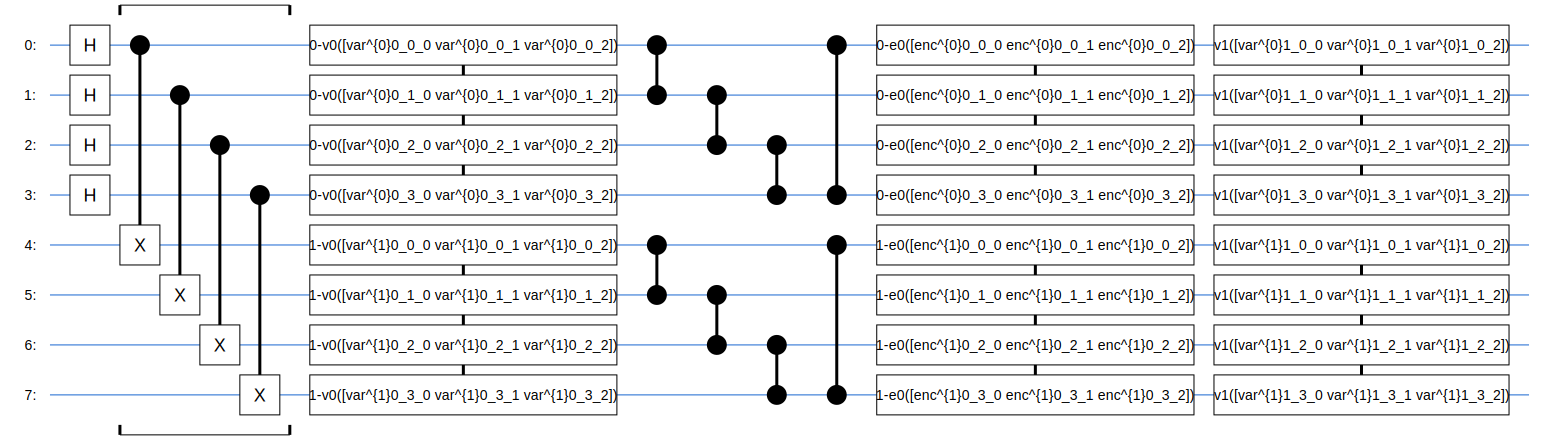

In [394]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(circuit)

In [395]:
class HybridPartiteVariationalEncodingPQC(keras.layers.Layer):
    
    def __init__(self, 
        qubits: list,
        n_parts: int, # Number of partitions.
        d_qubits: int, # Number of qubits per partition.
        n_layers: int,
        observables: list,
        name: str = None,
        squash_activation: str = 'linear',
        variational_layer_cls: ParameterizedOperationGate = VariationalRotationLayer,
        encoding_layer_cls: ParameterizedOperationGate = EncodingLayer,
        ):
        name = name or self.__class__.__name__
        super().__init__(name=name)
        
        self.n_layers = n_layers
        self.n_qubits = len(qubits)
        self.squash_activation = squash_activation
        
        # Build circuit.
        circuit, (symbols_var, symbols_enc) = self.generate_circuit(qubits, n_parts, d_qubits, n_layers, decompose=True, variational_layer_cls=variational_layer_cls, encoding_layer_cls=encoding_layer_cls)
        
        # Define trainable variables for TensorFlow layer.
        self.w_var = tf.Variable(
            initial_value=tf.random_uniform_initializer(minval=0.0, maxval=np.pi)(shape=symbols_var.shape, dtype='float32'),
            trainable=True,
            name='w_var',
        )
        # self.w_enc = tf.Variable(
        #     initial_value=tf.ones(shape=symbols_enc.shape, dtype='float32'),
        #     trainable=True,
        #     name='w_enc',
        # )
        
        # print(f"{self.w_var.shape=}")
        # print(f"{self.w_enc.shape=}")
        
        # Explicit symbol ordering.
        self.symbols = [str(s) for s in np.concatenate((symbols_var.flatten(), symbols_enc.flatten()))]
        self.symbols_idx = tf.constant([self.symbols.index(s) for s in sorted(self.symbols)]) # Cross-ref symbol with its index in the explicit ordering.
        
        # Empty circuit for batching.
        self.empty_circuit_tensor = tfq.convert_to_tensor([cirq.Circuit()])
        
        # The variational+encoding circuit for computation.
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
        
    def call(self, inputs):
        batch_size = tf.gather(tf.shape(inputs), 0)
        
        # Since input is batched, we must batch the TFQ circuits.
        batched_circuits = tf.repeat(self.empty_circuit_tensor, repeats=batch_size)
        
        # Batch the variational weight angles.
        angles_var = tf.reshape(tf.tile(self.w_var, multiples=[batch_size, *([1]*(len(self.w_var.shape)-1))]), shape=(-1, *self.w_var.shape))
        
        # Multiply input vectors by the encoding weights.
        # Preserves batching.
        # Einsum dimension labels:
        #   p = partition index
        #   b = batch
        #   l = layer
        #   q = qubit
        #   f = feature
        # angles_enc = tf.einsum("lqf,bq->blqf", self.w_enc, inputs)
        # angles_enc = tf.einsum("plqf,bpqf->bplqf", self.w_enc, inputs) # For each partition `p`, encode each `input` state feature `q` on the `q-th` qubit and repeat encoding on same qubit for every layer `l`. Number of input features must match number of qubits.
        _,p,q,f = inputs.shape
        angles_enc = tf.reshape(tf.tile(inputs, multiples=[1, 1, self.n_layers, 1]), shape=(-1,p,self.n_layers,q,f))
        
        # Squash the encoding input angles using the provided activation function.
        if self.squash_activation == 'arctan':
            angles_enc = tf.math.atan(angles_enc)
        else:
            angles_enc = keras.layers.Activation(self.squash_activation)(angles_enc)
        
        
        # Combine all angles into a single batched tensor.
        # This is necessary because TensorFlowQuantum requires parameters to be in 1D list format. Since the circuits are also batched, this turns into 2D with shape (batch_size, num_symbols).
        #
        # Since all angles are different shapes, compress each down to batched 2D and then concatenate along the feature dimension.
        joined_angles = tf.concat([
            tf.reshape(angles_var, (batch_size, -1)),
            tf.reshape(angles_enc, (batch_size, -1)),
        ], axis=1)
        #
        # Now reorder angles based on explicit symbol ordering.
        joined_angles = tf.gather(joined_angles, self.symbols_idx, axis=1)
        
        # Run batched angles.
        # Result will be 2D with shape (batch_size, num_observables).
        out = self.computation_layer([batched_circuits, joined_angles])
        
        return out
    
    @staticmethod
    def generate_circuit(*args, **kwargs):
        return generate_partite_variational_encoding_circuit(*args, **kwargs)

n_parts = 2
d_qubits = 4
n_layers = 5

qubits = cirq.LineQubit.range(n_parts * d_qubits)

observables = [
    cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 0,0
    cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 0,1
    cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 1,0
    cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 1,1
]
    
layer = HybridPartiteVariationalEncodingPQC(qubits, n_parts, d_qubits, n_layers, observables, squash_activation='arctan', encoding_layer_cls=ParameterizedRotationLayer_RxRyRz)
# layer.w_var.shape, layer.w_enc.shape, layer.symbols, layer.symbols_idx

# layer.w_enc.shape

x = np.random.random(size=(16, 2, 4, 3))
layer(x)

<tf.Tensor: shape=(16, 4), dtype=float32, numpy=
array([[ 0.09958456, -0.02730029,  0.09929235,  0.10058814],
       [ 0.1349448 , -0.00153799,  0.01714612,  0.1673554 ],
       [ 0.19554333,  0.13895397, -0.11773679,  0.02853908],
       [ 0.11221382,  0.18680945,  0.18665852,  0.04863634],
       [ 0.08658502, -0.09812407,  0.05247073,  0.03437796],
       [ 0.12366762,  0.07611492, -0.03609117,  0.12233897],
       [-0.00074417, -0.0410137 ,  0.09907587,  0.08928424],
       [-0.13899852,  0.09202689,  0.10044614,  0.02396935],
       [ 0.03969922,  0.0191498 ,  0.00760965,  0.1761312 ],
       [ 0.179226  ,  0.20226413,  0.04319116,  0.04341259],
       [ 0.03286292, -0.01443446,  0.08561959, -0.10620762],
       [ 0.02998481,  0.00113416, -0.24737646,  0.00876064],
       [ 0.06695472, -0.15805084, -0.02294357, -0.02570764],
       [ 0.14603941, -0.13123304,  0.06484678,  0.08268781],
       [ 0.04913974,  0.02548122, -0.0161632 ,  0.07791885],
       [ 0.0119776 , -0.00558233, -0

In [396]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [397]:
def generate_model_CoinGame2(
    qubits,
    n_agents,
    d_qubits,
    n_feat, # 1D Feature dimension of observable.
    n_layers,
    observables,
    is_target,
    ):
    
    # n_wires = len(qubits)
    
    # qubits = cirq.LineQubit.range(n_wires)
    
    qlayer = HybridPartiteVariationalEncodingPQC(
        qubits=qubits, 
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        # squash_activation='tanh',
        squash_activation='arctan',
        encoding_layer_cls=ParameterizedRotationLayer_RxRyRz,
        )

    model = keras.Sequential([
            keras.Input(shape=(n_agents, d_qubits, n_feat), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            qlayer,
            # CustomQuantumLayer(n_wires, n_layers, observables),
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            # keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model
    

In [398]:
import itertools
import functools

def make_observables_cartpole(qubits: list) -> list:
    return [
        cirq.Z(qubits[0]) * cirq.Z(qubits[1]),
        cirq.Z(qubits[2]) * cirq.Z(qubits[3]),
    ]


def make_observables_CoinGame2(qubits: list) -> list:
    return [
        cirq.Z(qubits[0]),
        cirq.Z(qubits[1]),
        cirq.Z(qubits[2]),
        cirq.Z(qubits[3]),
    ]


def permute_observables(observables: list[list]) -> list:
    return [
        functools.reduce(lambda x, y: x*y, obs)
        for obs in itertools.product(*observables)
        ]

In [399]:
# n_actions = 2 # because `env.action_space.n == 2`
# n_wires = 4 # because `env.observation_space.shape == (4,)`
# n_layers = 5

n_agents = 2
d_qubits = 4 # Observables will have shape (d_qubits,n_feat)
n_feat = 3
n_layers = 5

n_actions = 4 # CoinGame2 has 4 actions (north/south/east/west)

qubits = cirq.LineQubit.range(n_agents * d_qubits)

# observables = [
#     cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 0,0
#     cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 0,1
#     cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 1,0
#     cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 1,1
# ]

agent_obs = []
for aidx in range(n_agents):
    qidx = aidx * d_qubits # Starting qubit index for the current partition.
    
    obs = make_observables_CoinGame2(qubits[qidx:qidx+d_qubits])
    agent_obs.append(obs)

observables = permute_observables(agent_obs)

# Joint action --> per-agent action
joint_action_map = list(itertools.product(*list(itertools.repeat(list(range(n_actions)), n_agents))))
len(joint_action_map), joint_action_map, observables
# joint_action_map = [
#     (0,0),
#     (0,1),
#     (1,0),
#     (1,1),
# ]

(16,
 [(0, 0),
  (0, 1),
  (0, 2),
  (0, 3),
  (1, 0),
  (1, 1),
  (1, 2),
  (1, 3),
  (2, 0),
  (2, 1),
  (2, 2),
  (2, 3),
  (3, 0),
  (3, 1),
  (3, 2),
  (3, 3)],
 [Z(0)*Z(4),
  Z(0)*Z(5),
  Z(0)*Z(6),
  Z(0)*Z(7),
  Z(1)*Z(4),
  Z(1)*Z(5),
  Z(1)*Z(6),
  Z(1)*Z(7),
  Z(2)*Z(4),
  Z(2)*Z(5),
  Z(2)*Z(6),
  Z(2)*Z(7),
  Z(3)*Z(4),
  Z(3)*Z(5),
  Z(3)*Z(6),
  Z(3)*Z(7)])

In [400]:
model = generate_model_CoinGame2(
    qubits=qubits,
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_feat=n_feat,
    n_layers=n_layers,
    observables=observables,
    is_target=False,
    )

model_target = generate_model_CoinGame2(
    qubits=qubits,
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_feat=n_feat,
    n_layers=n_layers,
    observables=observables,
    is_target=True,
    )

print('setting weights')
model_target.set_weights(model.get_weights())

setting weights


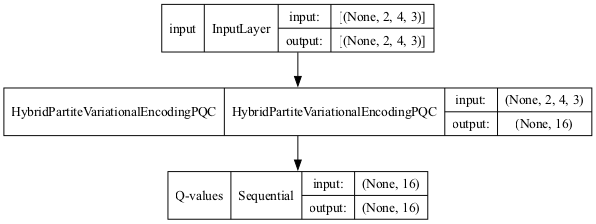

In [401]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70, to_file="model_classic.png")

In [402]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HybridPartiteVariationalEnc  (None, 16)               144       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 Q-values (Sequential)       (None, 16)                16        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [403]:
# x = np.random.random(size=(64, n_parts, 4,))
# model([x])

## Training

In [410]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)
# agent_replay_memory = [cl.deque(maxlen=max_memory_length) for i in range(n_agents)] # Separate replay memory for each agent.

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

# optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# # Assign the model parameters to each optimizer
# w_in, w_var, w_out = 1, 0, 2
w_var, w_out = 0, 1

# optimizer_w_tups = list(zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]))

In [411]:
### Q-learning update function.

# @tf.function
def eqqmix_update(states, actions, rewards, next_states, done, model, model_target, gamma, n_actions):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    # done = tf.convert_to_tensor(done)
    
    
    # # Convert termination signals into a joint signal.
    # done = tf.reduce_prod(done, axis=1)
    
    # # Convert individual rewards into a joint reward.
    # rewards = tf.reduce_mean(rewards, axis=1)
    rewards = tf.reduce_sum(rewards, axis=1)
    
    # print(f"{states=}")
    # print(f"{actions=}")
    # print(f"{rewards=}")
    # print(f"{next_states=}")
    # print(f"{done=}")
    # print(f"{tf.reduce_prod(done, axis=1)=}")
    

    # Compute target Q-values and masks on sampled actions.
    # with catchtime() as t:
    future_rewards = model_target([next_states])
    # print(f"{future_rewards=}")
    # print(f"{tf.reduce_max(future_rewards, axis=1)=}")
    # print(f"{tf.reduce_max(future_rewards, axis=-1)=}")
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    # print(f"{target_q_values=}")
    # print(f"[target_q_values] Execution time: {t():.4f} secs")
    
    # masks = tf.one_hot(actions, n_agents * n_actions)
    masks = tf.one_hot(actions, n_actions ** n_agents)
    # print(f"{actions=}")
    # print(f"{masks=}")
    
    
    # with catchtime() as t:
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # with catchtime() as t1:
        q_values = model([states])
        # print(f"[tape:eval] Execution time: {t1():.4f} secs")
        # print(f"{q_values=}")
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # print(f"{q_values_masked=}")
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
    # print(f"[tape] Execution time: {t():.4f} secs")
        
    # with catchtime() as t:
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    # for optimizer, w in optimizer_w_tups:
    # for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
    for optimizer, w in zip([optimizer_var, optimizer_out], [w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    # print(f"[backprop] Execution time: {t():.4f} secs")
        
    # # print(f"{loss=}")
    # # print(f"{grads=}")
    # # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")

In [412]:
def interact_env_CoinGame2(
    states,
    n_agents,
    model,
    epsilon,
    env,
    joint_action_map,
    ):
    
    # Preserve original state.
    states_original = states

    # Convert to observable grid for each agent's observation.
    states = np.asarray(states).reshape((1, n_agents, *env.observation_shape)) # Forces batch dimension of `1`.

    # Convert observable grid to feature vector for quantum encoding.
    states = map_observable_to_encoded_vector(states)

    # Convert to tensor.
    states = tf.convert_to_tensor(states)


    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([states])
        joint_action = int(tf.argmax(q_vals[0]).numpy())
        # print(f"{q_vals.shape=}")
        # print(f"{joint_action=}")
        # print(f"{joint_action_map[joint_action]=}")
    else: # Random action.
        joint_action = np.random.choice(n_agents * n_actions)
        # print(f"{joint_action=}")
        # print(f"{joint_action_map[joint_action]=}")

    # Apply joint action within environment.
    # Environment `.step()` requires joint action be a list of actions, one for each agent.
    jam = joint_action_map[joint_action]
    next_states, rewards, done, _ = env.step(jam)
    
    # print(f"{jam=}")
    # print(f"{next_states=}")
    # print(f"{rewards=}")
    # print(f"{done=}")
    # # print(f"{info=}")
    # print(f"{env.domain_values()=}")
    # print(f"{env.domain_value_labels=}")
    # print(f"{env.discounted_returns=}")
    # print(f"{env.undiscounted_returns=}")
    
    return dict(
        states=states_original,
        joint_action=joint_action,
        rewards=rewards,
        next_states=next_states,
        done=done,
    )


env_params = {
    "domain_name": "CoinGame-2",
    "R_max": 2,
    "time_limit": 50,
    "gamma": gamma,
}
env = coin_game_make(env_params)

episode_reward_history = []
step_count = 0

episode_discounted_reward_history = []
episode_undiscounted_reward_history = []
episode_coins_collected_history = []
episode_own_coins_collected_history = []
episode_own_coin_rate_history = []


for episode in range(n_episodes):
    episode_reward = 0
    episode_discounted_reward = 0
    episode_undiscounted_reward = 0
    episode_coins_collected = 0
    episode_own_coins_collected = 0
    episode_own_coin_rate = 0

    # Reset environment.
    states = env.reset()
    
    while True:
        interaction = interact_env_CoinGame2(
            states=states,
            n_agents=n_agents,
            model=model,
            epsilon=epsilon,
            env=env,
            joint_action_map=joint_action_map,
        )
        replay_memory.append(interaction)
        # print(f"{interaction=}")
        
        # Compute episode reward using aggregation function.
        episode_reward += tf.reduce_mean(interaction['rewards'])
        
        # Set next state as current state.
        states = interaction['next_states']
        
        # Increase step count.
        step_count += 1
        
        coins_collected = env.domain_values()[env.get_index('coins_collected')]
        own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
        
        # print(f"{env.undiscounted_returns=}")
        # print(f"{env.discounted_returns=}")
        # print(f"{coins_collected=}")
        # print(f"{own_coins_collected=}")
        
        episode_undiscounted_reward += np.sum(env.undiscounted_returns)
        episode_discounted_reward += np.sum(env.discounted_returns)
        episode_coins_collected += coins_collected
        episode_own_coins_collected += own_coins_collected
        
        # Compute "own coin rate", and treat all divide by zeros errors as zero.
        # div = np.divide(own_coins_collected, coins_collected, out=np.zeros_like(own_coins_collected), where=(coins_collected!=0))
        # print(f"{div=}")
        if coins_collected != 0:
            episode_own_coin_rate += own_coins_collected/coins_collected
        
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            # print(f"{training_batch=}")
            
            update_states = np.asarray([x['states'] for x in training_batch]).squeeze()
            update_actions = np.asarray([x['joint_action'] for x in training_batch]).squeeze()
            update_rewards = np.asarray([x['rewards'] for x in training_batch], dtype=np.float32).squeeze()
            update_next_states = np.asarray([x['next_states'] for x in training_batch]).squeeze()
            update_done = np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze()
            
            # Convert to observable grid for each agent's observation.
            update_states = update_states.reshape((-1, n_agents, *env.observation_shape)) # Forces batch dimension of `1`.

            # Convert observable grid to feature vector for quantum encoding.
            update_states = map_observable_to_encoded_vector(update_states)
            
            # Convert to observable grid for each agent's observation.
            update_next_states = update_next_states.reshape((-1, n_agents, *env.observation_shape)) # Forces batch dimension of `1`.

            # Convert observable grid to feature vector for quantum encoding.
            update_next_states = map_observable_to_encoded_vector(update_next_states)
            

            eqqmix_update(
                states=update_states,
                actions=update_actions,
                rewards=update_rewards,
                next_states=update_next_states,
                done=update_done,
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                # optimizer_w_tups=optimizer_w_tups,
                )
            # print('update')

        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        # print(f"{any(interaction['dones'])=}, {interaction['dones']=}")
        if interaction['done']:
            break
        
    # Decay epsilon.
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    
    episode_discounted_reward_history.append(episode_discounted_reward)
    episode_undiscounted_reward_history.append(episode_undiscounted_reward)
    episode_coins_collected_history.append(episode_coins_collected)
    episode_own_coins_collected_history.append(episode_own_coins_collected)
    episode_own_coin_rate_history.append(episode_own_coin_rate)

    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        avg_discounted_rewards = np.mean(episode_discounted_reward_history[-10:])
        avg_undiscounted_rewards = np.mean(episode_undiscounted_reward_history[-10:])
        avg_coins_collected = np.mean(episode_coins_collected_history[-10:])
        avg_own_coins_collected = np.mean(episode_own_coins_collected_history[-10:])
        avg_own_coin_rate = np.mean(episode_own_coin_rate_history[-10:])
        msg = "Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards)
        msg = f"{msg}: {avg_undiscounted_rewards=}, {avg_discounted_rewards=}, {avg_coins_collected=}, {avg_own_coins_collected=}, {avg_own_coin_rate=}"
        print(msg)

Episode 10/2000, average last 10 rewards 0.5: avg_undiscounted_rewards=22.5, avg_discounted_rewards=-0.4044676871720185, avg_coins_collected=984.3, avg_own_coins_collected=503.4, avg_own_coin_rate=71.37636674428083
Episode 20/2000, average last 10 rewards 0.4: avg_undiscounted_rewards=47.6, avg_discounted_rewards=6.460365105376608, avg_coins_collected=1051.2, avg_own_coins_collected=549.4, avg_own_coin_rate=78.11632159323753
Episode 30/2000, average last 10 rewards 0.25: avg_undiscounted_rewards=102.0, avg_discounted_rewards=11.487058622075889, avg_coins_collected=845.8, avg_own_coins_collected=473.9, avg_own_coin_rate=82.4719854002207
Episode 40/2000, average last 10 rewards -0.8: avg_undiscounted_rewards=-138.4, avg_discounted_rewards=-39.14755621340648, avg_coins_collected=947.2, avg_own_coins_collected=404.4, avg_own_coin_rate=54.85324649980225
Episode 50/2000, average last 10 rewards 0.65: avg_undiscounted_rewards=162.7, avg_discounted_rewards=64.17849833404233, avg_coins_collecte

KeyboardInterrupt: 

In [413]:
# model.save('q_qlearning_cirq', save_format='tf')
model.save_weights('q_eqmarl_cirq_coingame__weights')

In [414]:
model.load_weights('q_eqmarl_cirq_coingame__weights')

Text(0.5, 1.0, 'Episode Reward')

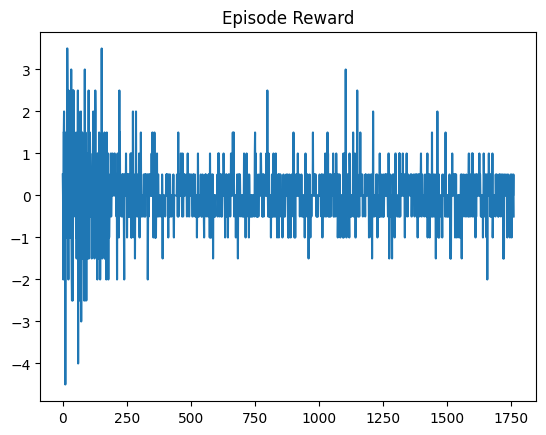

In [415]:
plt.plot(episode_reward_history)
plt.title('Episode Reward')

Text(0.5, 1.0, 'Coins Collected')

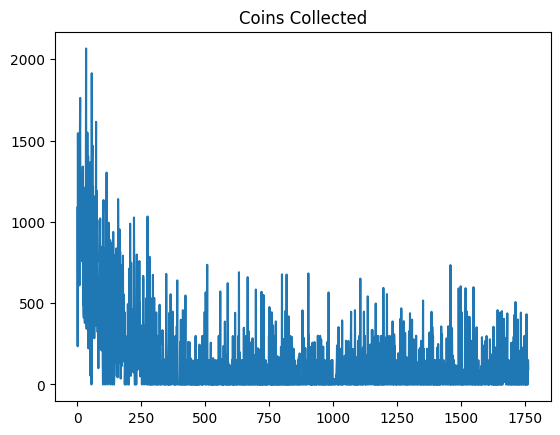

In [416]:
plt.plot(episode_coins_collected_history)
plt.title('Coins Collected')

Text(0.5, 1.0, 'Own Coins Collected')

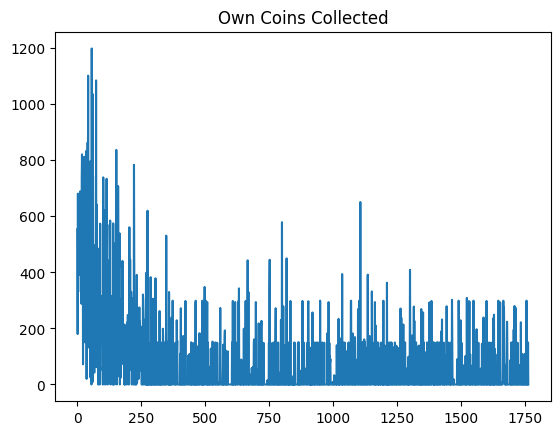

In [417]:
plt.plot(episode_own_coins_collected_history)
plt.title('Own Coins Collected')

Text(0.5, 1.0, 'Own Coin Rate')

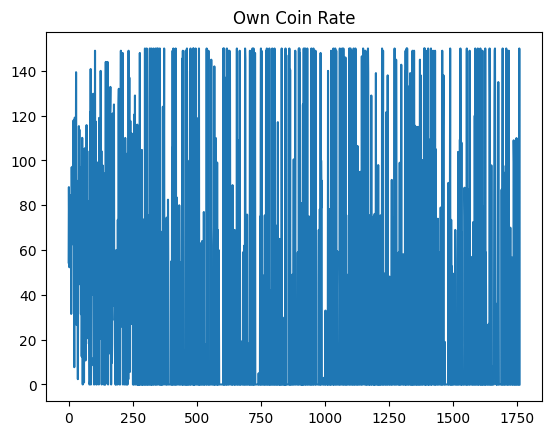

In [418]:
plt.plot(episode_own_coin_rate_history)
plt.title('Own Coin Rate')